# Resume Recommendation System

This notebook implements a resume recommendation system using a dataset of various resumes from different professions.

In [1]:
!pip install kagglehub

## 1. Import Required Libraries

First, we'll import all the necessary libraries for our analysis and model building.

In [4]:
# Import data handling libraries
import pandas as pd
import numpy as np
import os
import re
import kagglehub

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Import ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Humayun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Humayun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Humayun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Data Loading

Download and load the resume dataset.

In [3]:
# Download the dataset
dataset_path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print(f"Dataset downloaded to: {dataset_path}")

# List files in the dataset directory
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

KeyboardInterrupt: 

In [5]:
# Load the main CSV file
resume_path = r".cache\kagglehub\datasets\snehaanbhawal\resume-dataset\versions\1\Resume\Resume.csv"
resume_df = pd.read_csv(resume_path)

# Display basic information
print("Dataset Shape:", resume_df.shape)
resume_df.head()

Dataset Shape: (2484, 4)


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## 3. Feature Analysis

Let's analyze the features of our dataset.

In [6]:
# Display column information
print("Columns in the dataset:")
for col in resume_df.columns:
    dtype = resume_df[col].dtype
    non_null = resume_df[col].count()
    null = resume_df[col].isna().sum()
    unique = resume_df[col].nunique()
    
    print(f"- {col}: Type={dtype}, Non-null={non_null}, Null={null}, Unique Values={unique}")
    if dtype == 'object' and unique < 20:
        print(f"  Values: {resume_df[col].unique()}")

# Column types
print("\nData Types:")
print(resume_df.dtypes)

Columns in the dataset:
- ID: Type=int64, Non-null=2484, Null=0, Unique Values=2484
- Resume_str: Type=object, Non-null=2484, Null=0, Unique Values=2482
- Resume_html: Type=object, Non-null=2484, Null=0, Unique Values=2482
- Category: Type=object, Non-null=2484, Null=0, Unique Values=24

Data Types:
ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object


In [7]:
# Descriptive statistics for numerical columns
resume_df.describe()

,ID
count,2.484000e+03
mean,3.182616e+07
std,2.145735e+07
min,3.547447e+06
25%,1.754430e+07
50%,2.521031e+07
75%,3.611444e+07
max,9.980612e+07


## 4. Data Preprocessing

We'll now preprocess our data by handling missing values, outliers, and converting data types if needed.

In [8]:
# Check for missing values
print("Missing values per column:")
missing_values = resume_df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values (if any)
if resume_df.isnull().any().any():
    # Fill text columns with empty string
    for col in resume_df.select_dtypes(include=['object']).columns:
        resume_df[col] = resume_df[col].fillna('')
    
    # Fill numerical columns with median
    for col in resume_df.select_dtypes(include=['int64', 'float64']).columns:
        resume_df[col] = resume_df[col].fillna(resume_df[col].median())
    
    print("\nAfter handling missing values:")
    print(resume_df.isnull().sum().sum(), "missing values remaining")
else:
    print("\nNo missing values found.")

Missing values per column:
Series([], dtype: int64)

No missing values found.


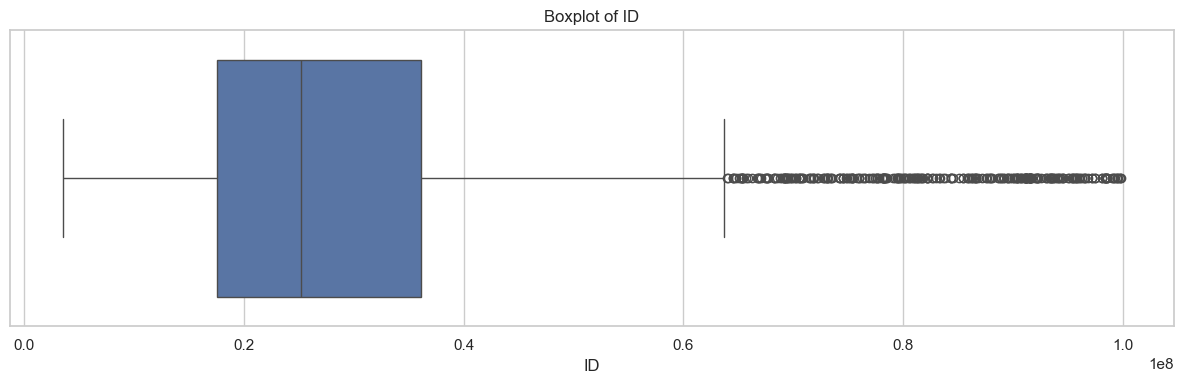

Column ID: 282 outliers detected

Total outliers handled: 282


In [9]:
# Check for outliers in numerical columns
numerical_cols = resume_df.select_dtypes(include=['int64', 'float64']).columns

if len(numerical_cols) > 0:
    plt.figure(figsize=(12, len(numerical_cols)*4))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols), 1, i)
        sns.boxplot(x=resume_df[col])
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()
    plt.show()
    
    # Function to handle outliers using IQR method
    def handle_outliers(df, col):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"Column {col}: {outliers} outliers detected")
        
        if outliers > 0:
            # Cap the outliers
            df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
            return outliers
        return outliers
    
    # Handle outliers for each numerical column
    total_outliers = 0
    for col in numerical_cols:
        total_outliers += handle_outliers(resume_df, col)
        
    print(f"\nTotal outliers handled: {total_outliers}")
else:
    print("No numerical columns to check for outliers.")

In [10]:
resume_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973.0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967.0,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873.0,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550.0,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897.0,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## 5. Data Visualization

Let's visualize our data to gain better insights.

In [11]:
# Create numerical features
resume_df['word_count'] = resume_df['Resume_str'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Display the first few rows to verify
print(resume_df['word_count'].head())

0     674
1     708
2    1017
3     379
4    1206
Name: word_count, dtype: int64


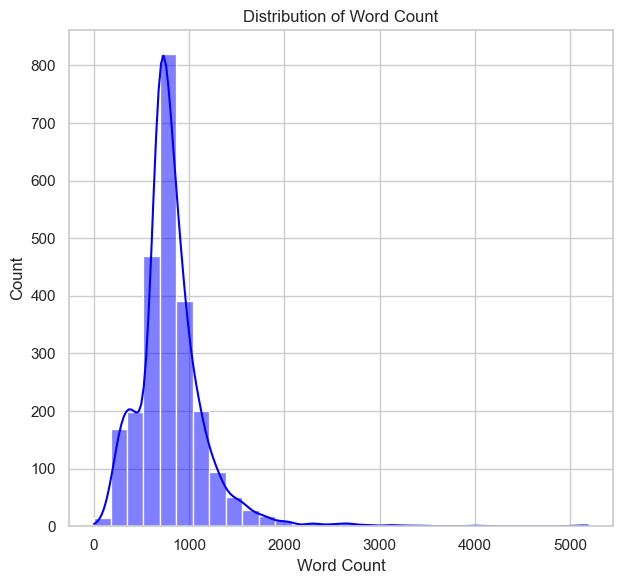

In [12]:
# Visualize distributions using histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(resume_df['word_count'], kde=True, bins=30, color='blue')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

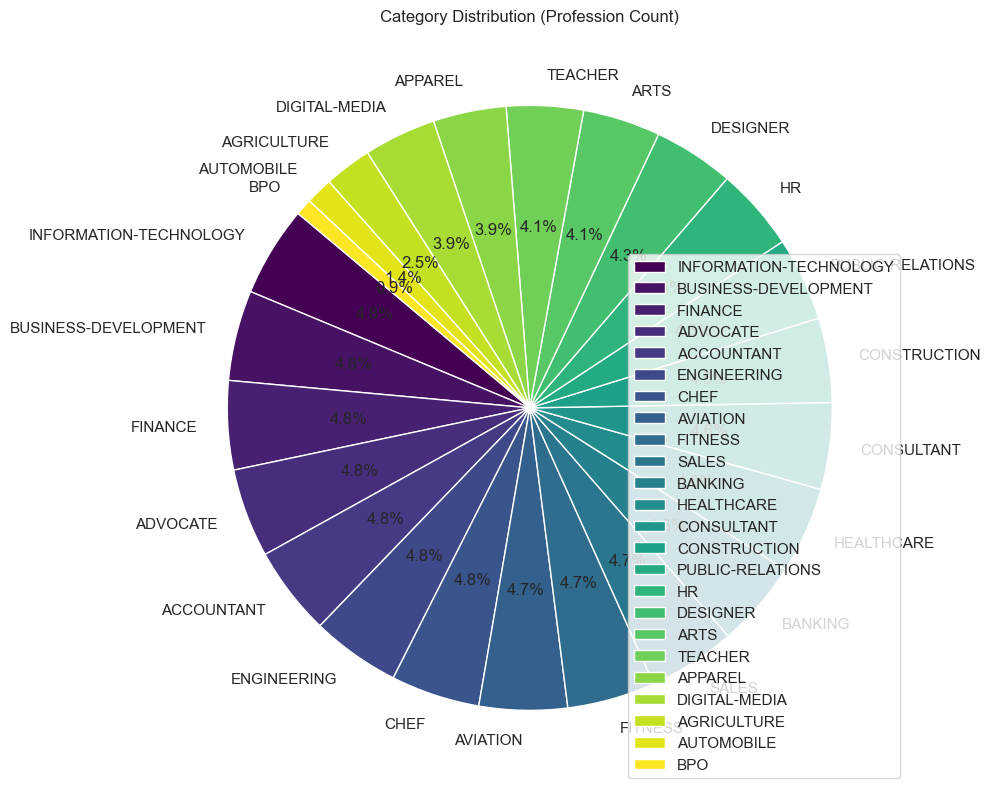

In [13]:
# Pie chart for category distribution
plt.figure(figsize=(10, 10))
resume_df['Category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='viridis', legend=True)
plt.title('Category Distribution (Profession Count)')
plt.ylabel('')
plt.tight_layout()
plt.show()

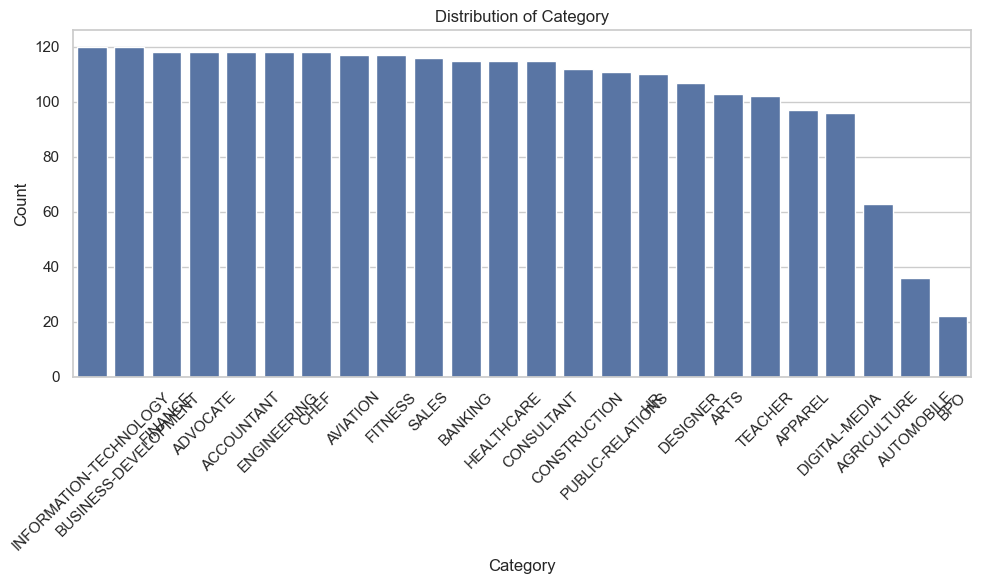

In [14]:
# Identify categorical columns (adjust as needed based on actual column names)
categorical_cols = resume_df.select_dtypes(include=['object']).columns

# Plot distribution of key categorical columns
for col in categorical_cols[:5]:  # Limit to first 5 to avoid too many plots
    if resume_df[col].nunique() < 100:  # Only plot if not too many unique values
        plt.figure(figsize=(10, 6))
        counts = resume_df[col].value_counts()
        sns.barplot(x=counts.index, y=counts.values)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

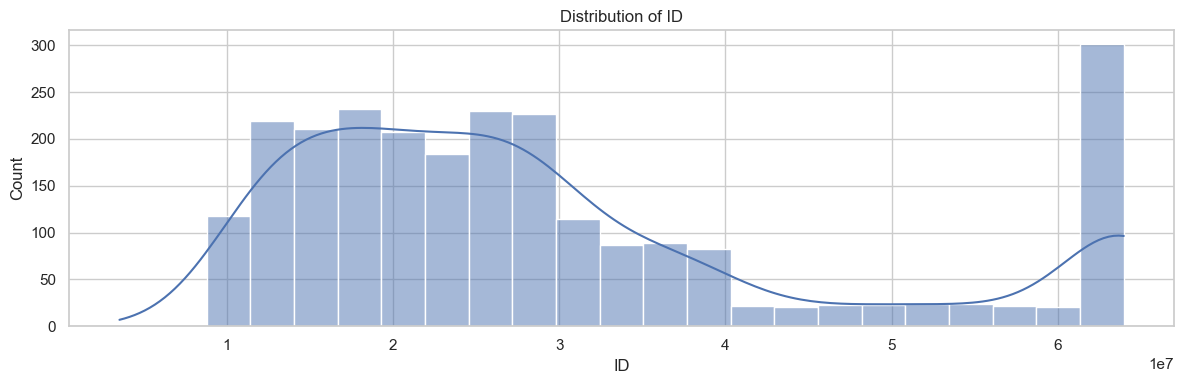

In [15]:
# Visualize numerical columns
if len(numerical_cols) > 0:
    # Histograms for numerical features
    plt.figure(figsize=(12, len(numerical_cols)*4))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols), 1, i)
        sns.histplot(resume_df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    

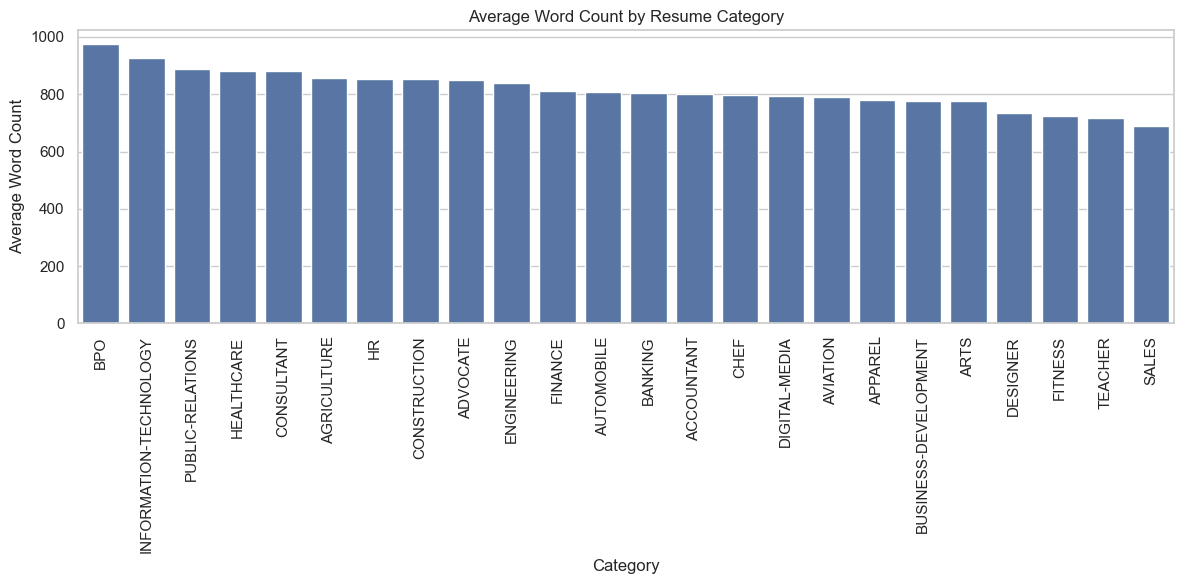

In [16]:
# Word count per category
plt.figure(figsize=(12, 6))
category_word_count = resume_df.groupby('Category')['word_count'].mean().sort_values(ascending=False)
sns.barplot(x=category_word_count.index, y=category_word_count.values)
plt.title('Average Word Count by Resume Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 6. Text Preprocessing

We'll now prepare the raw resume text for analysis by applying standard NLP preprocessing techniques:
- Converting to lowercase
- Removing punctuation, numbers, and special characters
- Removing stopwords
- Tokenizing the text
- Applying lemmatization to reduce words to their root form

In [17]:
# Define preprocessing function
def preprocess_text(text):
    # Check if text is string
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove very short words (length <= 2)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Join back to string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to the resume text
print("Preprocessing resume text...")
resume_df['processed_text'] = resume_df['Resume_str'].apply(preprocess_text)

# Display a sample of original vs. processed text
sample_idx = min(5, len(resume_df)-1)  # Get a valid index
print(f"\nSample Resume (Original first 300 chars):\n{resume_df['Resume_str'].iloc[sample_idx][:300]}")
print(f"\nSample Resume (Processed first 300 chars):\n{resume_df['processed_text'].iloc[sample_idx][:300]}")

# Check word count before and after preprocessing
resume_df['processed_word_count'] = resume_df['processed_text'].apply(lambda x: len(x.split()))
print(f"\nAverage original word count: {resume_df['word_count'].mean():.2f}")
print(f"Average processed word count: {resume_df['processed_word_count'].mean():.2f}")
print(f"Average word reduction: {((resume_df['word_count'] - resume_df['processed_word_count']) / resume_df['word_count']).mean() * 100:.2f}%")

Preprocessing resume text...

Sample Resume (Original first 300 chars):
         HR GENERALIST       Summary     Dedicated and focused Administrative Assistant who excels at prioritizing, completing multiple tasks simultaneously and following through to achieve project goals. Seeking a role of increased responsibility and authority.       Highlights         Microsoft Of

Sample Resume (Processed first 300 chars):
generalist summary dedicated focused administrative assistant excels prioritizing completing multiple task simultaneously following achieve project goal seeking role increased responsibility authority highlight microsoft office proficiency excel spreadsheet meticulous attention detail resultsoriente

Average original word count: 811.33
Average processed word count: 574.34
Average word reduction: 28.91%


## 7. Feature Extraction

Now we'll convert the preprocessed text into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency).
This technique gives higher weight to words that are important to a particular document and lower weight to commonly used words across documents.

In [18]:
# Create TF-IDF features
print("Creating TF-IDF features...")

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000,  # Limit features to prevent memory issues
                                   min_df=5,           # Ignore terms that appear in less than 5 documents
                                   max_df=0.8)         # Ignore terms that appear in more than 80% of documents

# Generate TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(resume_df['processed_text'])

# Display TFIDF information
print(f"TF-IDF features shape: {tfidf_features.shape}")
print(f"Number of unique terms: {len(tfidf_vectorizer.get_feature_names_out())}")

# Display top features (terms with highest IDF)
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_values = tfidf_vectorizer.idf_
feature_idf = dict(zip(feature_names, idf_values))
sorted_features = sorted(feature_idf.items(), key=lambda x: x[1], reverse=True)

print("\nTop 20 most important terms across documents:")
for term, idf in sorted_features[:20]:
    print(f"{term}: {idf:.4f}")

Creating TF-IDF features...
TF-IDF features shape: (2484, 5000)
Number of unique terms: 5000

Top 20 most important terms across documents:
knoxville: 7.0263
nexio: 7.0263
para: 7.0263
reservoir: 7.0263
teradata: 7.0263
vhf: 7.0263
asc: 6.8721
assay: 6.8721
cocktail: 6.8721
compounding: 6.8721
savannah: 6.8721
sushi: 6.8721
vocal: 6.8721
zumba: 6.8721
aix: 6.7386
ballet: 6.7386
bradley: 6.7386
essay: 6.7386
shipboard: 6.7386
aseptic: 6.6208


## 8. Label Encoding

Next, we'll encode the job categories into numerical labels for our machine learning models.

In [19]:
# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(resume_df['Category'])

# Display the encoding mapping
encoding_map = {idx: category for idx, category in enumerate(label_encoder.classes_)}
print("Category encoding:")
for idx, category in encoding_map.items():
    print(f"{idx}: {category}")

# Count the number of samples in each category
category_counts = resume_df['Category'].value_counts()
print("\nCategory distribution:")
for category, count in category_counts.items():
    print(f"{category}: {count} samples")

Category encoding:
0: ACCOUNTANT
1: ADVOCATE
2: AGRICULTURE
3: APPAREL
4: ARTS
5: AUTOMOBILE
6: AVIATION
7: BANKING
8: BPO
9: BUSINESS-DEVELOPMENT
10: CHEF
11: CONSTRUCTION
12: CONSULTANT
13: DESIGNER
14: DIGITAL-MEDIA
15: ENGINEERING
16: FINANCE
17: FITNESS
18: HEALTHCARE
19: HR
20: INFORMATION-TECHNOLOGY
21: PUBLIC-RELATIONS
22: SALES
23: TEACHER

Category distribution:
INFORMATION-TECHNOLOGY: 120 samples
BUSINESS-DEVELOPMENT: 120 samples
FINANCE: 118 samples
ADVOCATE: 118 samples
ACCOUNTANT: 118 samples
ENGINEERING: 118 samples
CHEF: 118 samples
AVIATION: 117 samples
FITNESS: 117 samples
SALES: 116 samples
BANKING: 115 samples
HEALTHCARE: 115 samples
CONSULTANT: 115 samples
CONSTRUCTION: 112 samples
PUBLIC-RELATIONS: 111 samples
HR: 110 samples
DESIGNER: 107 samples
ARTS: 103 samples
TEACHER: 102 samples
APPAREL: 97 samples
DIGITAL-MEDIA: 96 samples
AGRICULTURE: 63 samples
AUTOMOBILE: 36 samples
BPO: 22 samples


## 9. Train/Test Split

Now we'll split the data into training and testing sets, ensuring that we maintain the class distribution using stratified sampling.

In [20]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, y, test_size=0.2, random_state=42, stratify=y
)

# Print split information
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Verify class distribution in both sets
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)

print("\nClass distribution in training set:")
for idx, percentage in train_distribution.items():
    print(f"{encoding_map[idx]}: {percentage*100:.2f}%")

print("\nClass distribution in testing set:")
for idx, percentage in test_distribution.items():
    print(f"{encoding_map[idx]}: {percentage*100:.2f}%")

Training set: 1987 samples
Testing set: 497 samples

Class distribution in training set:
INFORMATION-TECHNOLOGY: 4.83%
BUSINESS-DEVELOPMENT: 4.83%
CHEF: 4.73%
ENGINEERING: 4.73%
FINANCE: 4.73%
ACCOUNTANT: 4.73%
FITNESS: 4.73%
ADVOCATE: 4.73%
SALES: 4.68%
AVIATION: 4.68%
HEALTHCARE: 4.63%
CONSULTANT: 4.63%
BANKING: 4.63%
CONSTRUCTION: 4.53%
PUBLIC-RELATIONS: 4.48%
HR: 4.43%
DESIGNER: 4.33%
ARTS: 4.13%
TEACHER: 4.13%
APPAREL: 3.93%
DIGITAL-MEDIA: 3.88%
AGRICULTURE: 2.52%
AUTOMOBILE: 1.46%
BPO: 0.91%

Class distribution in testing set:
CHEF: 4.83%
AVIATION: 4.83%
ADVOCATE: 4.83%
ENGINEERING: 4.83%
FINANCE: 4.83%
INFORMATION-TECHNOLOGY: 4.83%
ACCOUNTANT: 4.83%
BUSINESS-DEVELOPMENT: 4.83%
HEALTHCARE: 4.63%
CONSULTANT: 4.63%
BANKING: 4.63%
SALES: 4.63%
FITNESS: 4.63%
PUBLIC-RELATIONS: 4.43%
CONSTRUCTION: 4.43%
HR: 4.43%
DESIGNER: 4.23%
ARTS: 4.23%
TEACHER: 4.02%
DIGITAL-MEDIA: 3.82%
APPAREL: 3.82%
AGRICULTURE: 2.62%
AUTOMOBILE: 1.41%
BPO: 0.80%


## 10. Model Selection and Training

We'll train and evaluate several different classification models to find the best one for our resume classification task.

In [21]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Create a DataFrame from the classification report for better visualization
    report_df = pd.DataFrame(report).T
    report_df = report_df.drop('support', axis=1)  # Remove the support column for cleaner output
    
    # Display the classification report
    print("\nClassification Report:")
    display(report_df.style.format("{:.4f}").highlight_max(axis=0))
    
    return model, accuracy, report

# Import required modules
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Create a list of models to evaluate
models = [
    (MultinomialNB(), "Naive Bayes"),
    (LogisticRegression(max_iter=1000, C=1.0, solver='liblinear'), "Logistic Regression"),
    (LinearSVC(C=1.0, max_iter=10000), "Linear SVM"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest")
]

# Dictionary to store results
results = {}

In [22]:
# Import time module which is needed for evaluate_model function
import time
from IPython.display import display
from sklearn.metrics import confusion_matrix

# Train and evaluate each model
for model, model_name in models:
    fitted_model, accuracy, report = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    results[model_name] = {
        'model': fitted_model,
        'accuracy': accuracy,
        'report': report
    }


Naive Bayes Results:
Training time: 0.01 seconds
Accuracy: 0.5533

Classification Report:


c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
ACCOUNTANT,0.5122,0.8750,0.6462
ADVOCATE,0.3846,0.4167,0.4000
AGRICULTURE,1.0000,0.0769,0.1429
APPAREL,0.5000,0.0526,0.0952
ARTS,0.7500,0.1429,0.2400
AUTOMOBILE,0.0000,0.0000,0.0000
AVIATION,0.8235,0.5833,0.6829
BANKING,0.8750,0.6087,0.7179
BPO,0.0000,0.0000,0.0000
BUSINESS-DEVELOPMENT,0.3393,0.7917,0.4750



Logistic Regression Results:
Training time: 0.74 seconds
Accuracy: 0.6419

Classification Report:


c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
ACCOUNTANT,0.6667,0.8333,0.7407
ADVOCATE,0.3636,0.5000,0.4211
AGRICULTURE,1.0000,0.3846,0.5556
APPAREL,0.6000,0.1579,0.2500
ARTS,0.5000,0.2857,0.3636
AUTOMOBILE,0.0000,0.0000,0.0000
AVIATION,0.8571,0.7500,0.8000
BANKING,0.8824,0.6522,0.7500
BPO,0.0000,0.0000,0.0000
BUSINESS-DEVELOPMENT,0.4390,0.7500,0.5538



Linear SVM Results:
Training time: 0.33 seconds
Accuracy: 0.7183

Classification Report:


,precision,recall,f1-score
ACCOUNTANT,0.7143,0.8333,0.7692
ADVOCATE,0.7200,0.7500,0.7347
AGRICULTURE,0.8750,0.5385,0.6667
APPAREL,0.5385,0.3684,0.4375
ARTS,0.5294,0.4286,0.4737
AUTOMOBILE,1.0000,0.4286,0.6000
AVIATION,0.8182,0.7500,0.7826
BANKING,0.8571,0.7826,0.8182
BPO,0.0000,0.0000,0.0000
BUSINESS-DEVELOPMENT,0.5263,0.8333,0.6452



Random Forest Results:
Training time: 3.63 seconds
Accuracy: 0.6761

Classification Report:


c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humayun\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
ACCOUNTANT,0.6562,0.8750,0.7500
ADVOCATE,0.7308,0.7917,0.7600
AGRICULTURE,1.0000,0.3077,0.4706
APPAREL,0.7778,0.3684,0.5000
ARTS,0.3333,0.0952,0.1481
AUTOMOBILE,1.0000,0.1429,0.2500
AVIATION,0.7727,0.7083,0.7391
BANKING,0.7500,0.5217,0.6154
BPO,0.0000,0.0000,0.0000
BUSINESS-DEVELOPMENT,0.4651,0.8333,0.5970


## 11. Model Evaluation

Now let's compare the performance of all models and visualize their results.

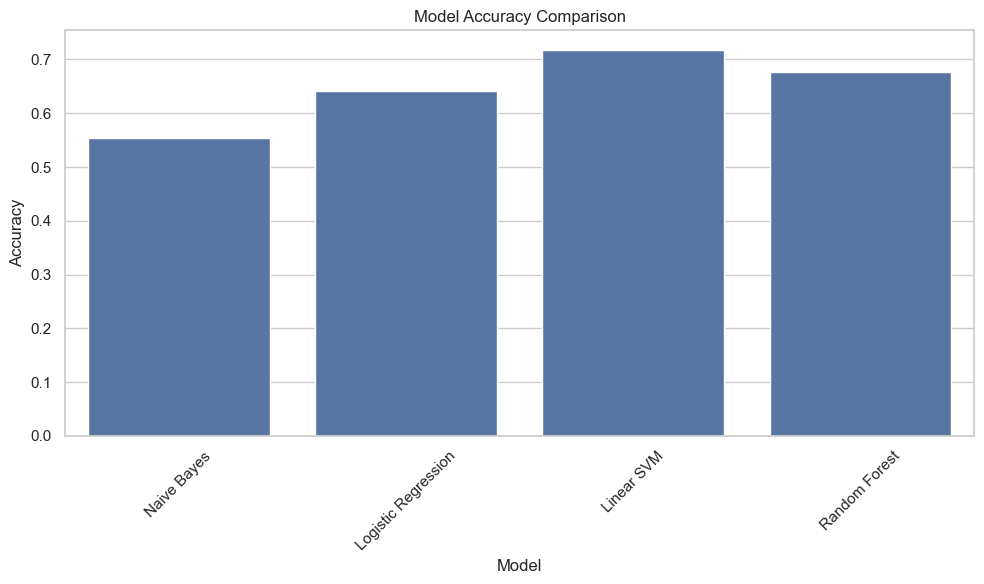

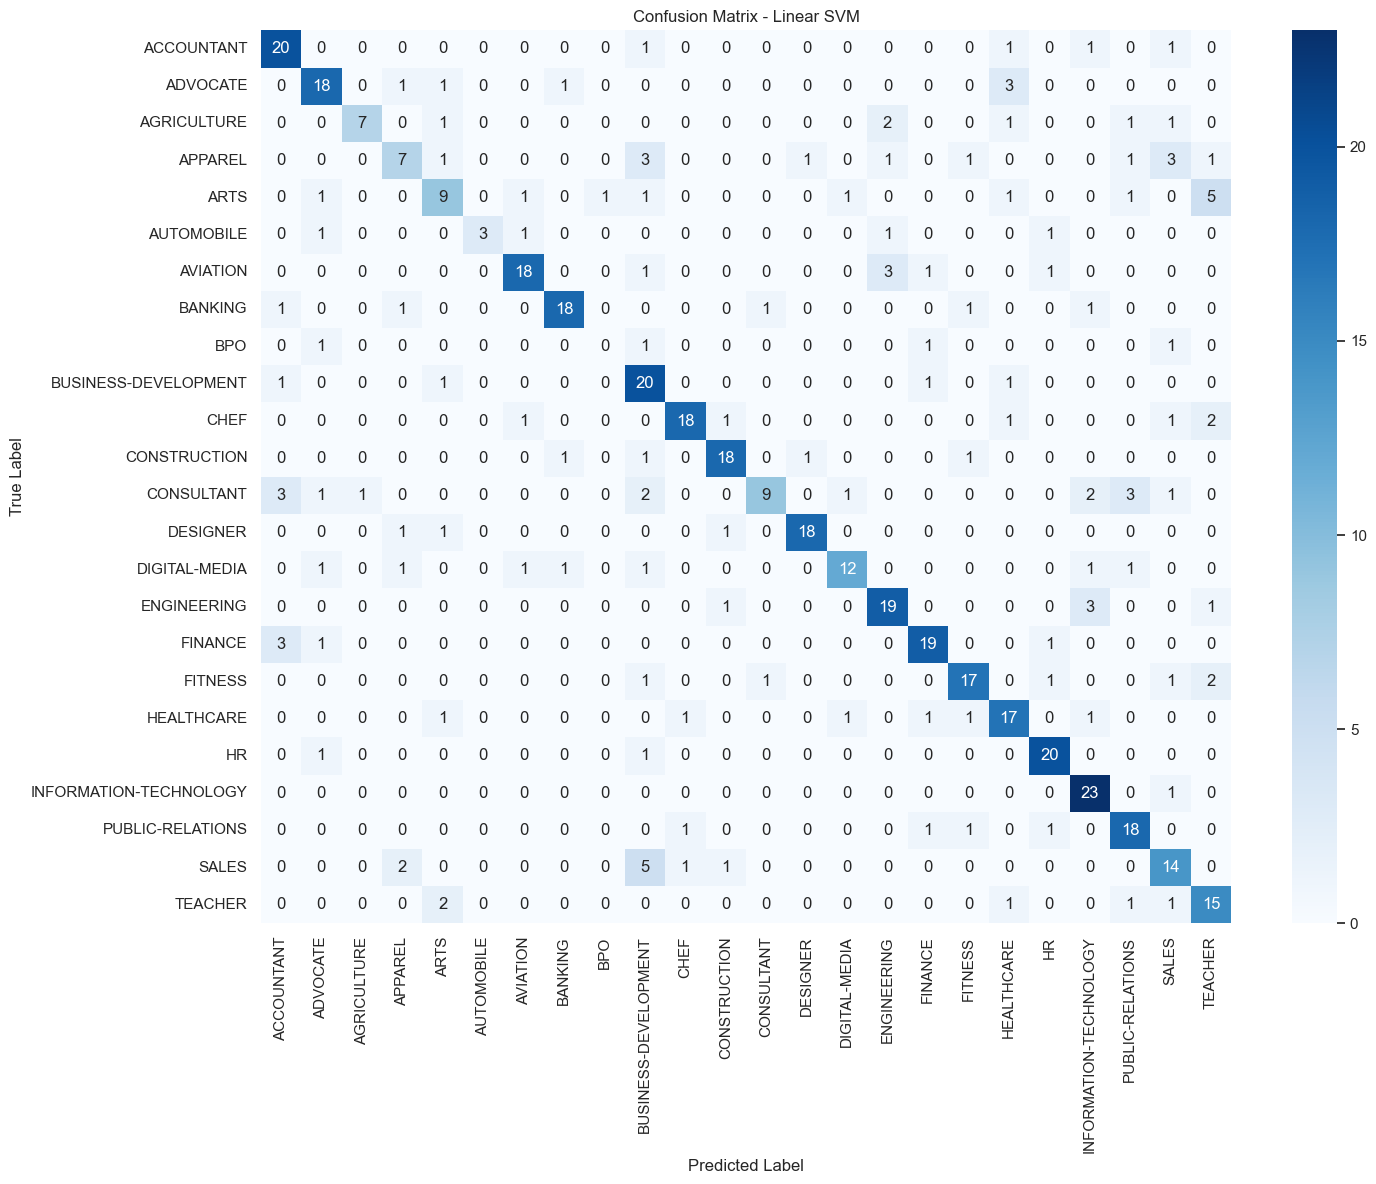


The best performing model is Linear SVM with an accuracy of 0.7183

Categories with the lowest F1-scores:
BPO: 0.0000
APPAREL: 0.4375
ARTS: 0.4737
CONSULTANT: 0.5294
SALES: 0.5833


In [23]:
# Compare model accuracies
accuracies = {name: result['accuracy'] for name, result in results.items()}
best_model_name = max(accuracies, key=accuracies.get)
best_model = results[best_model_name]['model']

# Visualize model accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Get predictions from the best model
y_pred = best_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nThe best performing model is {best_model_name} with an accuracy of {accuracies[best_model_name]:.4f}")

# Find the categories with the lowest F1-scores
f1_scores = {}
for category, metrics in results[best_model_name]['report'].items():
    if category not in ['macro avg', 'weighted avg', 'accuracy']:
        f1_scores[category] = metrics['f1-score']

# Sort categories by F1-score
sorted_f1_scores = dict(sorted(f1_scores.items(), key=lambda x: x[1]))

# Display the 5 lowest performing categories
print("\nCategories with the lowest F1-scores:")
for i, (category, f1) in enumerate(sorted_f1_scores.items()):
    if i < 5:  # Show only the 5 worst performing categories
        print(f"{category}: {f1:.4f}")

## 12. Feature Importance Analysis

Let's analyze which features (words) are most important for classification.

In [ ]:
# Feature importance analysis (for models that support it)
if best_model_name == "Random Forest":
    # Get feature importance from Random Forest
    feature_importance = best_model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create a dataframe of feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display the top 20 most important features
    print("Top 20 most important features (Random Forest):")
    display(importance_df.head(20))
    
    # Visualize the top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()
    
elif best_model_name in ["Logistic Regression", "Linear SVM"]:
    # For linear models, we can get coefficients
    if hasattr(best_model, 'coef_'):
        feature_names = tfidf_vectorizer.get_feature_names_out()
        n_classes = len(label_encoder.classes_)
        
        # For each class, get the top features
        for i in range(min(5, n_classes)):  # Show for first 5 classes
            class_name = label_encoder.classes_[i]
            
            if best_model_name == "Logistic Regression" and n_classes > 2:
                # For multiclass logistic regression
                coefficients = best_model.coef_[i]
            elif best_model_name == "Linear SVM" and n_classes > 2:
                # For multiclass SVM
                coefficients = best_model.coef_[i]
            else:
                # For binary classification
                coefficients = best_model.coef_[0]
            
            # Create a dataframe of coefficients
            coef_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefficients
            })
            
            # Sort by absolute coefficient value
            coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
            coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
            
            # Display the top 10 most important features for this class
            print(f"\nTop 10 most important features for {class_name}:")
            display(coef_df.head(10)[['Feature', 'Coefficient']])


Top 10 most important features for ACCOUNTANT:


,Feature,Coefficient
33,accountant,3.764631
35,accounting,1.687286
1836,finance,-1.114816
1618,entry,0.886014
823,closing,0.754958
3691,reconciled,0.693605
3256,payroll,0.657985
2733,manager,-0.654640
3545,proper,0.638222
455,balance,0.615318



Top 10 most important features for ADVOCATE:


,Feature,Coefficient
129,advocate,5.440094
761,child,1.014237
1131,court,0.898688
178,aix,0.892310
1977,fundraising,0.858428
3566,provider,0.846830
2239,illinois,0.833817
463,banker,0.807842
2134,healthcare,-0.769684
4816,victim,0.753583



Top 10 most important features for AGRICULTURE:


,Feature,Coefficient
163,agriculture,2.225613
1913,formulation,0.944617
4199,soil,0.865301
2546,land,0.827322
162,agricultural,0.767794
2912,molecular,0.741075
1744,extension,0.690597
1621,epic,0.670461
4886,water,0.652281
1787,farmer,0.651347



Top 10 most important features for APPAREL:


,Feature,Coefficient
260,apparel,2.769722
2837,merchandising,1.374729
4366,stylist,1.279298
1788,fashion,1.147908
4330,store,1.022150
3506,production,0.873100
354,assistant,0.861081
2733,manager,0.860599
4037,seasonal,0.848342
1889,food,-0.764250



Top 10 most important features for ARTS:


,Feature,Coefficient
318,art,3.197871
1279,dental,1.297252
2767,martial,1.119851
1203,dance,1.106199
4012,school,1.064114
755,chef,-1.035654
1589,english,0.983737
2366,instructor,0.854867
1402,disposition,0.827616
1150,creative,0.821008


## 13. Resume Recommendation System

Now that we have a trained model, let's create a simple recommendation system to suggest suitable job categories for new resumes.

In [25]:
def recommend_job_categories(resume_text, model, vectorizer, label_encoder, top_n=3):
    """Recommend top N job categories for a given resume text."""
    # Preprocess the resume text
    processed_text = preprocess_text(resume_text)
    
    # Vectorize the processed text
    text_vector = vectorizer.transform([processed_text])
    
    # For models that provide probability estimates
    if hasattr(model, 'predict_proba'):
        # Get probability estimates
        probabilities = model.predict_proba(text_vector)[0]
        
        # Sort indices by probability in descending order
        sorted_indices = probabilities.argsort()[::-1]
        
        # Get the top N categories and their probabilities
        recommendations = [(label_encoder.classes_[idx], probabilities[idx]) for idx in sorted_indices[:top_n]]
    else:
        # For models without probability estimates, use decision function if available
        if hasattr(model, 'decision_function'):
            # Get decision scores
            decision_scores = model.decision_function(text_vector)[0]
            
            # Handle binary classification case
            if decision_scores.ndim == 0:
                decision_scores = np.array([1 - decision_scores, decision_scores])
            
            # Sort indices by score in descending order
            sorted_indices = decision_scores.argsort()[::-1]
            
            # Get the top N categories and their scores
            recommendations = [(label_encoder.classes_[idx], decision_scores[idx]) for idx in sorted_indices[:top_n]]
        else:
            # Fallback to just predicting the class
            prediction = model.predict(text_vector)[0]
            recommendations = [(label_encoder.classes_[prediction], 1.0)]
    
    return recommendations

# Example resume text (use sample_resume from the dataset or provide your own)
if 'sample_resume' in globals():
    example_resume = sample_resume
else:
    # Use a sample from the dataset
    example_resume = resume_df['Resume_str'].iloc[10]  # Just a random sample

# Get recommendations using the best model
recommendations = recommend_job_categories(
    example_resume,
    results[best_model_name]['model'],
    tfidf_vectorizer,
    label_encoder,
    top_n=5
)

# Display recommendations
print("\nResume excerpt:")
print(example_resume[:500] + "..." if len(example_resume) > 500 else example_resume)

print("\nRecommended job categories:")
for category, score in recommendations:
    print(f"{category}: {score:.4f}")


Resume excerpt:
         HR ASSISTANT       Summary    Highly motivated, and a dynamic Human Resources professional with diverse credentials seeking a position with a growing organization to make a positive impact on company policies, and experience career growth. Accomplished human resources and administrative professional with over 3 years' experience. Attentive to detail, able to take initiative, prioritize multiple tasks and manage workload. Resourceful team player with a can-do attitude. Results-driven wit...

Recommended job categories:
HR: 0.6669
CONSULTANT: -0.8387
ADVOCATE: -0.9040
BPO: -0.9649
ARTS: -0.9698


In [27]:
import pickle

# Save the best model (Linear SVM)
with open('resume_model.pkl', 'wb') as f:
    pickle.dump(results[best_model_name]['model'], f)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Artifacts saved: resume_model.pkl, tfidf_vectorizer.pkl, label_encoder.pkl")

Artifacts saved: resume_model.pkl, tfidf_vectorizer.pkl, label_encoder.pkl


## 14. Conclusion and Future Improvements

We've successfully built a resume classification and recommendation system. Here's a summary of what we've accomplished and potential future improvements.

### Summary of Results

- We processed and analyzed a dataset of resumes from various job categories
- Applied text preprocessing techniques to clean and normalize the resume text
- Created TF-IDF features to represent the resumes numerically
- Trained and evaluated multiple machine learning models for resume classification
- Built a simple recommendation system to suggest job categories for new resumes

### Future Improvements

1. **Advanced Feature Engineering**:
   - Extract structural features (education, experience, skills sections)
   - Use named entity recognition to identify organizations, degrees, etc.
   - Include document layout/formatting features

2. **Better Text Representation**:
   - Use pre-trained word embeddings (Word2Vec, GloVe)
   - Implement transformer-based models (BERT, RoBERTa) for better semantic understanding
   - Try sentence-level embeddings

3. **Model Improvements**:
   - Hyperparameter tuning using grid search or random search
   - Ensemble multiple models for better performance
   - Address class imbalance with techniques like SMOTE or class weights

4. **User Interface**:
   - Create a web application for users to upload resumes and get recommendations
   - Provide detailed feedback on why certain categories were recommended
   - Include visualization of resume strengths and weaknesses

5. **Additional Features**:
   - Skill gap analysis between resume and job requirements
   - Resume improvement suggestions
   - Matching with actual job postings